# Setup

In [54]:
import numpy as np
import pandas as pd
import gc
import torch
from keras.preprocessing import image
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

os.chdir('../rfiw2021')

from Track1.models import Net
from Track1.utils import *

sns.set_palette("dark")

Defining constants

In [55]:
FILE = 'Track1'
SAMPLE = 'Track1/sample0/' # Path to sample image
TEST_PATH = '../notebooks/data/test_ag.csv'
MODEL_PATH = '../notebooks/data/model_track1.pth'
THRESHOLD = 0.11546290665864944 # Classification threshold
BATCH_SIZE = 40

Loading the model

In [56]:
model = Net().cuda()
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

Net(
  (encoder): KitModel(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn0): BatchNorm2d(64, eps=1.9999999494757503e-05, momentum=0.8999999761581421, affine=True, track_running_stats=True)
    (stage1_unit1_bn1): BatchNorm2d(64, eps=1.9999999494757503e-05, momentum=0.8999999761581421, affine=True, track_running_stats=True)
    (stage1_unit1_conv1sc): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (stage1_unit1_conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (stage1_unit1_sc): BatchNorm2d(64, eps=1.9999999494757503e-05, momentum=0.8999999761581421, affine=True, track_running_stats=True)
    (stage1_unit1_bn2): BatchNorm2d(64, eps=1.9999999494757503e-05, momentum=0.8999999761581421, affine=True, track_running_stats=True)
    (stage1_unit1_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (stage1_unit1_bn3): BatchNorm2d(64, eps=1.9999999494757503e-05, momentum=0.8999999761581421, affin

Loading the test database

In [57]:
test_samples = pd.read_csv(TEST_PATH)
test_samples

,face1_path,face2_path,kin_relation,is_kin,f1fid,f1mid,f1fp,f2fid,f2mid,f2fp,f1_age,f1_gender,f1_gender_score,f2_age,f2_gender,f2_gender_score,delta_age
0,Test/test-faces/face3118.jpg,Test/test-faces/face322.jpg,bb,1,Test,test-faces,face3118.jpg,Test,test-faces,face322.jpg,42.52,female,0.997070,52.09,female,0.997559,9.57
1,Test/test-faces/face1058.jpg,Test/test-faces/face322.jpg,bb,1,Test,test-faces,face1058.jpg,Test,test-faces,face322.jpg,38.88,female,0.997070,52.09,female,0.997559,13.21
2,Test/test-faces/face4234.jpg,Test/test-faces/face322.jpg,bb,1,Test,test-faces,face4234.jpg,Test,test-faces,face322.jpg,37.58,female,0.997070,52.09,female,0.997559,14.51
3,Test/test-faces/face4375.jpg,Test/test-faces/face322.jpg,bb,1,Test,test-faces,face4375.jpg,Test,test-faces,face322.jpg,36.10,female,0.997070,52.09,female,0.997559,15.99
4,Test/test-faces/face4360.jpg,Test/test-faces/face322.jpg,ss,1,Test,test-faces,face4360.jpg,Test,test-faces,face322.jpg,40.13,female,0.997070,52.09,female,0.997559,11.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36993,Test/test-faces/face4389.jpg,Test/test-faces/face5024.jpg,ms,1,Test,test-faces,face4389.jpg,Test,test-faces,face5024.jpg,81.71,female,0.992188,48.82,male,0.997559,32.89
36994,Test/test-faces/face3604.jpg,Test/test-faces/face5024.jpg,ms,1,Test,test-faces,face3604.jpg,Test,test-faces,face5024.jpg,82.84,female,0.991211,48.82,male,0.997559,34.02
36995,Test/test-faces/face1181.jpg,Test/test-faces/face5024.jpg,fs,0,Test,test-faces,face1181.jpg,Test,test-faces,face5024.jpg,14.17,male,0.997559,48.82,male,0.997559,34.65
36996,Test/test-faces/face3647.jpg,Test/test-faces/face5024.jpg,bb,0,Test,test-faces,face3647.jpg,Test,test-faces,face5024.jpg,12.04,female,0.979492,48.82,male,0.997559,36.78


# Making predictions on the test samples

In [58]:
def read_image(path):
    img = image.load_img(f"{FILE}/{path}", target_size=(112, 112))
    img = np.array(img).astype(float)
    return np.transpose(img, (2, 0, 1))

def gen(df: pd.DataFrame, batch_size):
    total = len(df)
    start = 0
    while True:
        if start + batch_size < total:
            end = start + batch_size
        else:
            end = total
        batch_list = df[start:end]
        datas=[]
        labels=[]
        classes=[]
        for index, row in batch_list.iterrows():
            datas.append([row['face1_path'],row['face2_path']])
            labels.append(int(row['is_kin']))
            classes.append(row['kin_relation'])
        X1 = np.array([read_image(x[0]) for x in datas])
        X2 = np.array([read_image(x[1]) for x in datas])
        yield X1, X2, labels,classes,batch_list
        start = end
        if start == total:
            yield None,None,None,None,None
        gc.collect()

In [59]:
predictions = []
with torch.no_grad():
    for img1, img2, labels, classes, batch_list in tqdm(gen(test_samples, BATCH_SIZE), total=len(test_samples) // BATCH_SIZE):
        if img1 is not None:
            img1 = torch.from_numpy(img1).type(torch.float).cuda()
            img2 = torch.from_numpy(img2).type(torch.float).cuda()
            em1, em2, _, _ = model([img1, img2])
            pred = torch.cosine_similarity(em1, em2, dim=1).cpu().detach().numpy().tolist()
            for i in range(len(pred)):
                if pred[i] >= THRESHOLD:
                    p = 1
                else:
                    p = 0
                predictions.append(p)
        else:
            break
test_samples['pred'] = pd.Series(predictions)
test_samples.to_csv('../notebooks/data/test_rfiw2021.csv', index=False)

  0%|          | 2/924 [00:03<29:12,  1.90s/it]


KeyboardInterrupt: 

# Results

In [ ]:
results = pd.read_csv('../notebooks/data/test_rfiw2021.csv')
FP = results[results['pred'] == 1][results['is_kin'] == 0]
FN = results[results['pred'] == 0][results['is_kin'] == 1]
TP = results[results['pred'] == 1][results['is_kin'] == 1]
TN = results[results['pred'] == 0][results['is_kin'] == 0]

Confusion Matrix

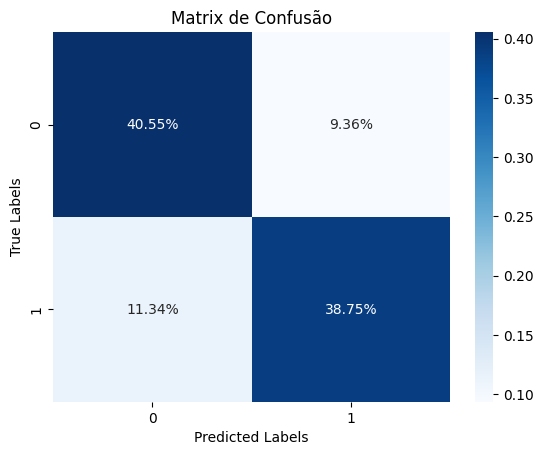

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(results['is_kin'], results['pred'], normalize='all')

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2%")

ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")

plt.title('Matrix de Confusão')
plt.show()

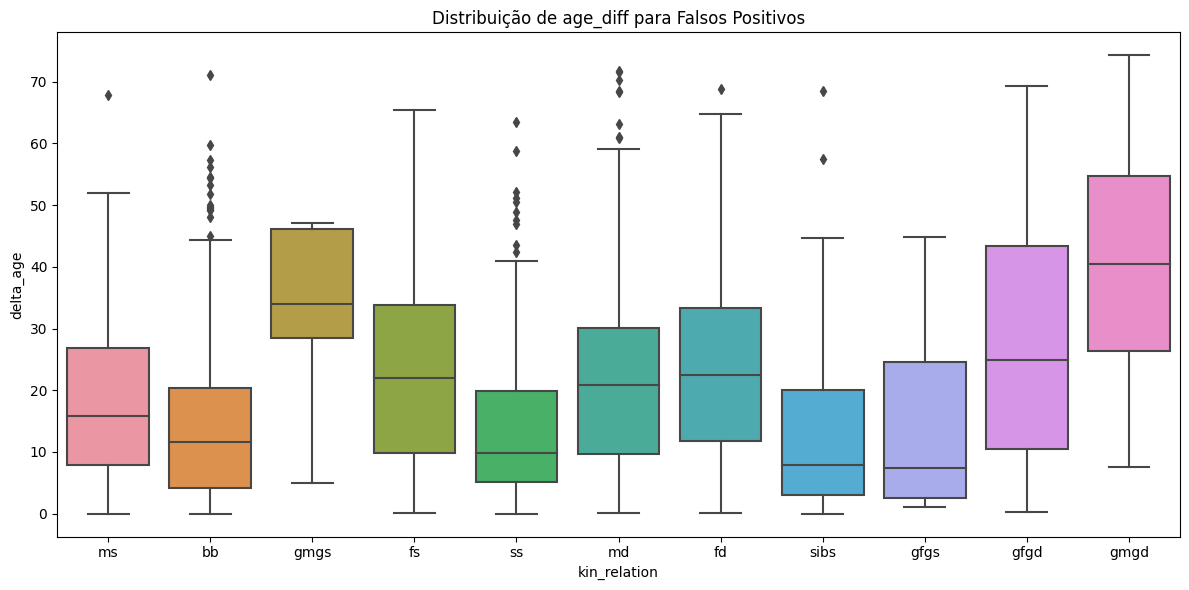

In [ ]:
plt.figure(figsize=(12, 6))

sns.boxplot(x='kin_relation', y='delta_age', data=FP)
plt.title('Distribuição de age_diff para Falsos Positivos')

plt.tight_layout()
plt.show()

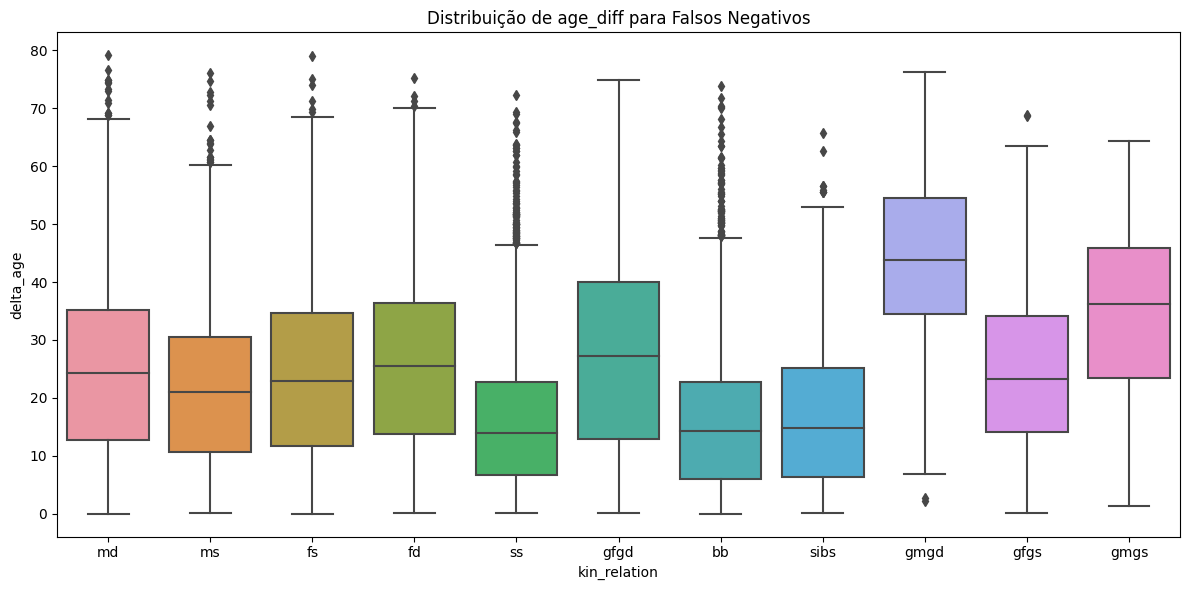

In [ ]:
plt.figure(figsize=(12, 6))

sns.boxplot(x='kin_relation', y='delta_age', data=TN)
plt.title('Distribuição de age_diff para Falsos Negativos')

plt.tight_layout()
plt.show()

In [61]:
def plot_distribution(df_a, df_b, a, b, title):
    # Calcular a distribuição de age_diff por kin_relation para os dois dataframes
    a_distribution = df_a.groupby('kin_relation')['delta_age'].mean().reset_index()
    b_distribution = df_b.groupby('kin_relation')['delta_age'].mean().reset_index()

    a_distribution['Category'] = a
    b_distribution['Category'] = b

    merged_data = pd.concat([a_distribution, b_distribution])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='kin_relation', y='delta_age', hue='Category', data=merged_data, palette=['#db3e2a', '#0eeba5'])

    plt.xlabel('Tipo de Parentesco')
    plt.ylabel('Média de Delta Age')
    plt.title(title)

    plt.xticks(rotation=45)
    plt.legend(title='Categorias', loc='upper right')
    plt.tight_layout()
    plt.show()

Aqui é possível observar uma diferença considerável entre a média de diferença de idade entre os irmãos

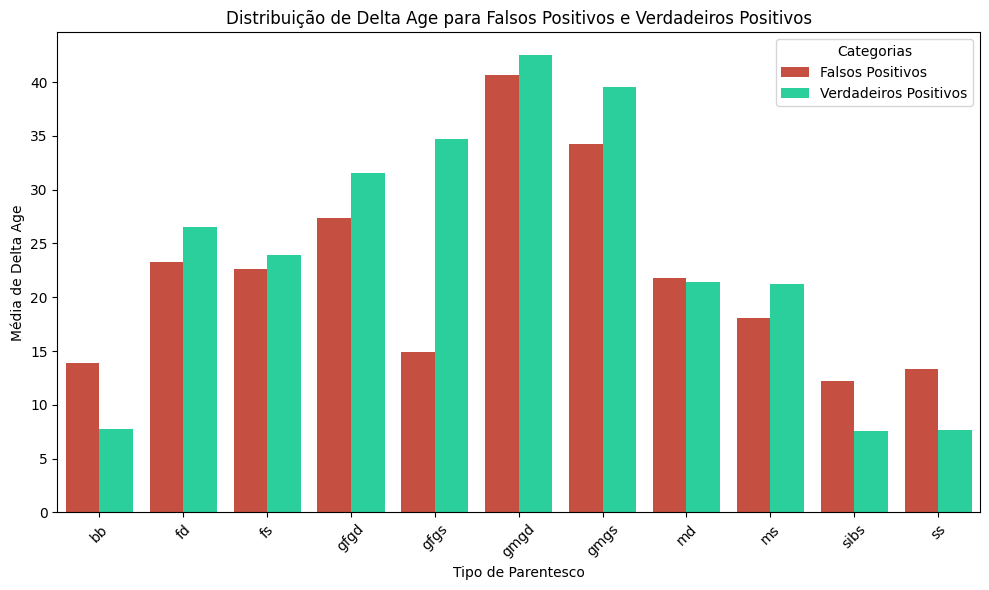

In [62]:
plot_distribution(FP, TP, 'Falsos Positivos', 'Verdadeiros Positivos', 'Distribuição de Delta Age para Falsos Positivos e Verdadeiros Positivos')

In [53]:
results['kin_relation'].value_counts()

kin_relation
bb      6814
fs      6005
md      5889
fd      5594
ss      5323
ms      4737
sibs    1576
gfgd     426
gmgd     233
gfgs     228
gmgs     173
Name: count, dtype: int64